In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_1772875/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Good Morning News"
SPLITS_FREQ = "7d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = None


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 352 non-null    object        
 1   author             352 non-null    object        
 2   date               352 non-null    datetime64[us]
 3   start              352 non-null    datetime64[us]
 4   end                352 non-null    datetime64[us]
 5   platform_proposal  352 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 16.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        1431 non-null   object        
 1   proposal  1431 non-null   object        
 2   voter     1431 non-null   object        
 3   date      1431 non-null   datetime64[us]
dtypes: d

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Good Morning News/baseline/folds-info_7d_normalize.parquet
fold
2022-11-20    1328
2022-11-27    1342
2022-12-04    1351
2022-12-11    1361
2022-12-18    1376
2022-12-25    1390
2023-01-01    1399
2023-01-08    1411
2023-01-15    1420
2023-01-22    1422
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2022-W46,1,2,2,2.00,1.00,1,1,1.00,1.00
2022-W47,1,0,0,0.00,nan,2,2,2.00,1.00
2022-W48,1,1,1,1.00,1.00,1,1,1.00,1.00
2022-W49,0,0,0,nan,nan,0,0,nan,nan
2022-W50,1,1,1,1.00,1.00,1,1,1.00,1.00
2022-W51,1,1,1,1.00,1.00,1,1,1.00,1.00
2022-W52,0,0,0,nan,nan,0,0,nan,nan
2023-W01,1,1,1,1.00,1.00,2,2,2.00,1.00
2023-W02,0,0,0,nan,nan,0,0,nan,nan


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2022-W46 & 1 & 2 & 2 & 2.00 & 1.00 & 1 & 1 & 1.00 & 1.00 \\
2022-W47 & 1 & 0 & 0 & 0.00 & nan & 2 & 2 & 2.00 & 1.00 \\
2022-W48 & 1 & 1 & 1 & 1.00 & 1.00 & 1 & 1 & 1.00 & 1.00 \\
2022-W49 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2022-W50 & 1 & 1 & 1 & 1.00 & 1.00 & 1 & 1 & 1.00 & 1.00 \\
2022-W51 & 1 & 1 & 1 & 1.00 & 1.00 & 1 & 1 & 1.00 & 1.00 \\
2022-W52 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W01 & 1 & 1 & 1 & 1.00 & 1.00 & 2 & 2 & 2.00 & 1.00 \\
2023-W02 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W03 & 1 & 0 & 0 & 0.00 & nan & 2 & 2 & 2.00 & 1.00 \\
\end{tabular}



## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

    if ok_in_a_row > max_ok_in_a_row[0]:
        max_ok_in_a_row = (ok_in_a_row, t)

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row[0] == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/50 [00:00<?, ?it/s]

Warning, empty test fold 0 (2022-02-13 00:00:00), all ok since 0 folds ago
Warning, test fold 1 (2022-02-20 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 2 (2022-02-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 3 (2022-03-06 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 4 (2022-03-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 5 (2022-03-20 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 6 (2022-03-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 7 (2022-04-03 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 8 (2022-04-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 9 (2022-04-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 10 (2022-04-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 11 (2022-05-01 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 12 (2022-05-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 13 (2022-05-15 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 14 (2022-05-22 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 15 (2022-05-29 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 16 (2022-06-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 17 (2022-06-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 18 (2022-06-19 00:00:00), all ok since 18 folds ago
Warning, test fold 19 (2022-06-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 20 (2022-07-03 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 21 (2022-07-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 22 (2022-07-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 23 (2022-07-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 24 (2022-07-31 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 25 (2022-08-07 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 26 (2022-08-14 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 27 (2022-08-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 28 (2022-08-28 00:00:00), all ok since 10 folds ago
Warning, test fold 29 (2022-09-04 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 30 (2022-09-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 31 (2022-09-18 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 32 (2022-09-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 33 (2022-10-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 34 (2022-10-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 35 (2022-10-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 36 (2022-10-23 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 37 (2022-10-30 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 38 (2022-11-06 00:00:00), all ok since 10 folds ago
Warning, empty test fold 39 (2022-11-13 00:00:00), all ok since 1 folds ago


Warning, test fold 40 (2022-11-20 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 41 (2022-11-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 42 (2022-12-04 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 43 (2022-12-11 00:00:00), all ok since 4 folds ago
Warning, test fold 44 (2022-12-18 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 45 (2022-12-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 46 (2023-01-01 00:00:00), all ok since 3 folds ago
Warning, test fold 47 (2023-01-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 48 (2023-01-15 00:00:00), all ok since 2 folds ago
Warning, test fold 49 (2023-01-22 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Max ok in a row: (18, Timestamp('2022-06-12 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Good Morning News/baseline/openpop_7d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.780000,0.260000,0.15600,0.078000,0.052000,0.007800,0.780000,0.780000,0.780000,0.780000,...,0.780000,0.780000,0.780000,0.780000,0.780000,0.780000,0.780000,0.780000,0.780000,0.107631
std,0.418452,0.139484,0.08369,0.041845,0.027897,0.004185,0.418452,0.418452,0.418452,0.418452,...,0.418452,0.418452,0.418452,0.418452,0.418452,0.418452,0.418452,0.418452,0.418452,0.019846
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068523
25%,1.000000,0.333333,0.20000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.114550
50%,1.000000,0.333333,0.20000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.115604
75%,1.000000,0.333333,0.20000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.120390
max,1.000000,0.333333,0.20000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.123896


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Good Morning News/baseline/perfect_7d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.840000,0.280000,0.168000,0.084000,0.056000,0.008400,0.840000,0.840000,0.840000,0.840000,...,0.840000,0.840000,0.840000,0.840000,0.840000,0.840000,0.840000,0.840000,0.840000,0.116253
std,0.370328,0.123443,0.074066,0.037033,0.024689,0.003703,0.370328,0.370328,0.370328,0.370328,...,0.370328,0.370328,0.370328,0.370328,0.370328,0.370328,0.370328,0.370328,0.370328,0.018558
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072884
25%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.120962
50%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.122284
75%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.126836
max,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.129552


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,50,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,0.0,0.0
mean,2022-08-03 12:00:00,0.780000,0.260000,0.15600,0.078000,0.052000,0.007800,0.780000,0.780000,0.780000,...,0.780000,0.780000,0.780000,0.780000,0.780000,0.780000,0.780000,0.107631,NaN,NaN
min,2022-02-13 00:00:00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068523,NaN,NaN
25%,2022-05-09 18:00:00,1.000000,0.333333,0.20000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.114550,NaN,NaN
50%,2022-08-03 12:00:00,1.000000,0.333333,0.20000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.115604,NaN,NaN
75%,2022-10-28 06:00:00,1.000000,0.333333,0.20000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.120390,NaN,NaN
max,2023-01-22 00:00:00,1.000000,0.333333,0.20000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.123896,NaN,NaN
std,NaN,0.418452,0.139484,0.08369,0.041845,0.027897,0.004185,0.418452,0.418452,0.418452,...,0.418452,0.418452,0.418452,0.418452,0.418452,0.418452,0.418452,0.019846,NaN,NaN


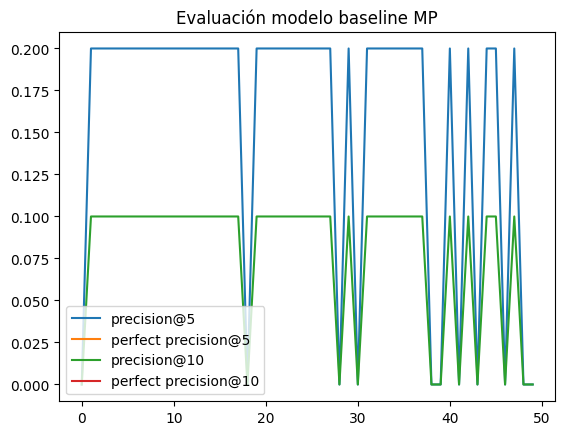

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0
mean,2022-12-21 12:00:00,0.500000,0.166667,0.100000,0.050000,0.033333,0.00500,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.094124,NaN,NaN
min,2022-11-20 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068523,NaN,NaN
25%,2022-12-05 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070138,NaN,NaN
50%,2022-12-21 12:00:00,0.500000,0.166667,0.100000,0.050000,0.033333,0.00500,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.094312,NaN,NaN
75%,2023-01-06 06:00:00,1.000000,0.333333,0.200000,0.100000,0.066667,0.01000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.117115,NaN,NaN
max,2023-01-22 00:00:00,1.000000,0.333333,0.200000,0.100000,0.066667,0.01000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.120413,NaN,NaN
std,NaN,0.527046,0.175682,0.105409,0.052705,0.035136,0.00527,0.527046,0.527046,0.527046,...,0.527046,0.527046,0.527046,0.527046,0.527046,0.527046,0.527046,0.025001,NaN,NaN
